In [6]:
import numpy as np
import descent
import matplotlib.pyplot as plt
#from IPython.html.widgets import interact
from ipywidgets import interact
%matplotlib inline

# Introduction to the descent package

Let's say we want to optimize the following:

$$ \text{minimize}\quad f(x) $$

given a computable expression for $f(x)$ and $\nabla f(x)$.

## Organization

Descent contains a number of agorithms that can be used to perform unconstrained and constrained optimization. These algorithms are split into two types, the _first-order gradient-based algorithms_ and _proximal algorithms_.

Proximal algorithms:
- Proximal Consensus / Alternating direction method of multipliers (ADMM)
- Proximal gradient descent
- Accelerated proximal gradient descent

First-order gradient-based algorithms:
- Gradient descent (can be stochastic, with or without momentum)
- [Stochastic average gradient (SAG)](http://arxiv.org/abs/1309.2388)
- RMSProp
- [Adam](http://arxiv.org/abs/1412.6980)


## Toy example

For an introductory example, consider the following toy function (a quadratic):
$$ f(x) = \frac{1}{2} x^Tx $$

In [7]:
# quadratic in n-dimensions
def f_df(x):
    objective = 0.5 * x.T.dot(x)
    gradient = x
    return objective, gradient

In [15]:
# initial guess
x0 = np.random.randn(10)

In [16]:
# optimize with gradient descent
algorithm = descent.algorithms.sgd(lr=0.1)
opt = descent.GradientDescent(x0, f_df, algorithm)
opt.run(maxiter=100)

+----------------+----------------+
|iteration       | objective      |
+----------------+----------------+
|              0 |          4.1396|
|              1 |           3.353|
|              2 |           2.716|
|              3 |          2.1999|
|              4 |          1.7819|
|              5 |          1.4434|
|              6 |          1.1691|
|              7 |           0.947|
|              8 |         0.76707|
|              9 |         0.62133|
|             10 |         0.50327|
|             11 |         0.40765|
|             12 |          0.3302|
|             13 |         0.26746|
|             14 |         0.21664|
|             15 |         0.17548|
|             16 |         0.14214|
|             17 |         0.11513|
|             18 |        0.093258|
|             19 |        0.075539|
|             20 |        0.061186|
|             21 |        0.049561|
|             22 |        0.040144|
|             23 |        0.032517|
|             24 |        0.

The learned parameters are stored in the `theta` property:

In [17]:
opt.theta

array([ -8.08669581e-06,   2.41698706e-05,  -8.42071040e-06,
         2.70291799e-05,  -1.27900727e-05,  -1.67045577e-05,
         3.15611336e-05,  -3.38602374e-05,   2.62718469e-05,
         2.16164009e-06])

By default, the objective function at every iteration is stored in a list, and accessed through the `store` property:

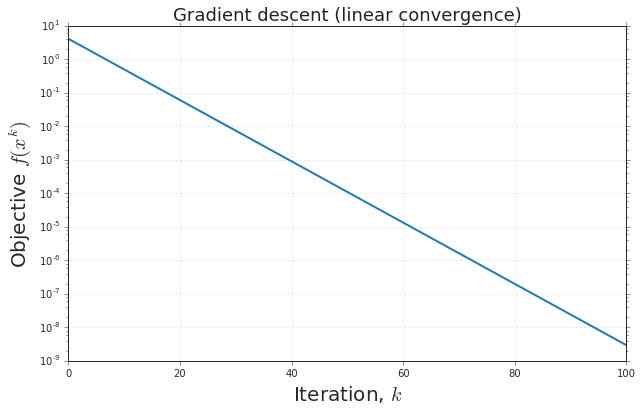

In [18]:
plt.figure(figsize=(10,6))
plt.semilogy(opt.store['objective'])
plt.xlabel('Iteration, $k$', fontsize=20)
plt.ylabel('Objective $f(x^k)$', fontsize=20)
plt.title('Gradient descent (linear convergence)', fontsize=18)

## Proximal operators

See the `descent.proximal_operators` module

For example, here is the proximal operator for the $\ell_1$-norm, with $\lambda = 0.1$ (the soft thresholding function):

In [20]:
# get the proximal operator
proxop = descent.proxops.sparse(0.1)

# this returns a callable object that evaluates the proximal operator given a starting location and a value for rho:
# apply it to a random value, with a given value of rho
x = np.arange(5)
print('Input: ', x)
rho = 1
print('After applying the prox. op.:', proxop.send((x, rho)))

Input:  [0 1 2 3 4]
After applying the prox. op.: [ 0.   0.9  1.9  2.9  3.9]


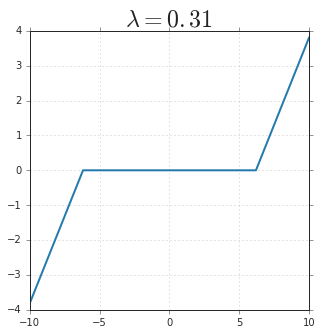

In [22]:
# explore the impact of the penalty parameter
@interact(penalty=(0.01, 0.5, 0.05))
def plot_prox(penalty=0.1):

    # get the proximal operator
    proxop = descent.proxops.sparse(penalty)
    
    # set the value of rho
    rho = 0.05
    
    x = np.linspace(-10,10,1e3)
    y = proxop.send((x, rho))

    plt.figure(figsize=(5,5))
    plt.title('$\lambda = {}$'.format(penalty), fontsize=24)
    plt.plot(x,y)

Here is another example, the proximal operator for the nuclear norm (penalty encourages low-rank solutions):

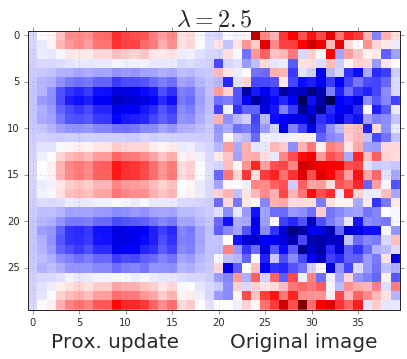

In [23]:
# apply it to a matrix
u = np.cos(4*np.linspace(0,np.pi,30))
v = np.sin(np.linspace(0,np.pi,20))
X = np.outer(u, v) + 0.3 * np.random.randn(30,20)
rho = 1.

@interact(penalty=(0.0, 5.0, 0.5))
def plot_prox(penalty=0.05):

    proxop = descent.proxops.nucnorm(penalty)
    X_lr = proxop.send((X, rho))

    plt.figure(figsize=(10,5))
    plt.title('$\lambda = {}$'.format(penalty), fontsize=24)
    plt.imshow(np.hstack([X_lr, X]), aspect='equal', cmap='seismic', interpolation='none')
    plt.xlabel('Prox. update        Original image', fontsize=20)